<a href="https://colab.research.google.com/github/naga-dheeraj-p/Assignments/blob/main/LSTM(pending)%20%2B%20Crypto_Momentum_Prediction_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [109]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [110]:
data=pd.read_csv('/content/gdrive/MyDrive/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv.zip')
data['Timestamp'] = pd.to_datetime(data.iloc[:, 0], unit='s')
data.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4857372,2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202
4857376,2021-03-31 00:00:00,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363


In [111]:
data.drop(columns=['Volume_(Currency)','Weighted_Price'],inplace=True)
data['returns'] = ((data['Close'] / data['Open']) - 1) * 100 #calculating returns for each hour
data.set_index('Timestamp', inplace=True)
data.tail()

,Open,High,Low,Close,Volume_(BTC),returns
Timestamp,,,,,,
2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,-0.048217
2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,0.003135
2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,0.051812
2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,0.031340
2021-03-31 00:00:00,58767.75,58778.18,58755.97,58778.18,2.712831,0.017748


In [112]:
hourly_data = data.resample('H').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last','Volume_(BTC)': 'sum','returns': 'mean'})  # Assuming 'returns' is a column representing minute-level returns
daily_data=hourly_data.resample('D').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume_(BTC)': 'sum', 'returns': 'mean'})
hourly_data.reset_index(inplace=True)
hourly_data.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),returns
81061,2021-03-30 20:00:00,59118.91,59135.00,58402.82,58669.04,118.576288,-0.013386
81062,2021-03-30 21:00:00,58644.04,58872.27,58570.57,58759.04,57.605048,0.008879
81063,2021-03-30 22:00:00,58758.44,58941.34,58642.58,58711.15,68.019168,-0.000902
81064,2021-03-30 23:00:00,58699.43,58770.38,58567.11,58760.59,78.329260,0.001545
81065,2021-03-31 00:00:00,58767.75,58778.18,58755.97,58778.18,2.712831,0.017748


In [113]:
rolling_returns = hourly_data['returns'].rolling(window=30).mean() #calculating mean
std_dev = hourly_data['returns'].rolling(window=30).std() #calculating std deviation

daily_rolling_returns=daily_data['returns'].rolling(window=30).mean()
daily_std_dev = daily_data['returns'].rolling(window=30).std()

In [114]:
k=2 # Selected this due to lesser number of false signals
hourly_data['overreaction'] = np.where(hourly_data['returns'] > rolling_returns + k * std_dev, 1,
                                    np.where(hourly_data['returns'] < rolling_returns - k * std_dev, -1, 0))

daily_data['overreaction'] = np.where(daily_data['returns'] > daily_rolling_returns + k * daily_std_dev, 1,
                                    np.where(daily_data['returns'] < daily_rolling_returns - k * daily_std_dev, -1, 0))

In [115]:
hourly_data.head()
daily_data.head()

,Open,High,Low,Close,Volume_(BTC),returns,overreaction
Timestamp,,,,,,,
2011-12-31,4.39,4.58,4.39,4.58,95.317878,0.388889,0
2012-01-01,4.58,5.00,4.58,5.00,21.602000,0.000000,0
2012-01-02,5.00,5.00,5.00,5.00,19.048000,0.000000,0
2012-01-03,5.32,5.32,5.14,5.29,88.037281,0.000000,0
2012-01-04,4.93,5.57,4.93,5.57,107.233260,0.651827,0


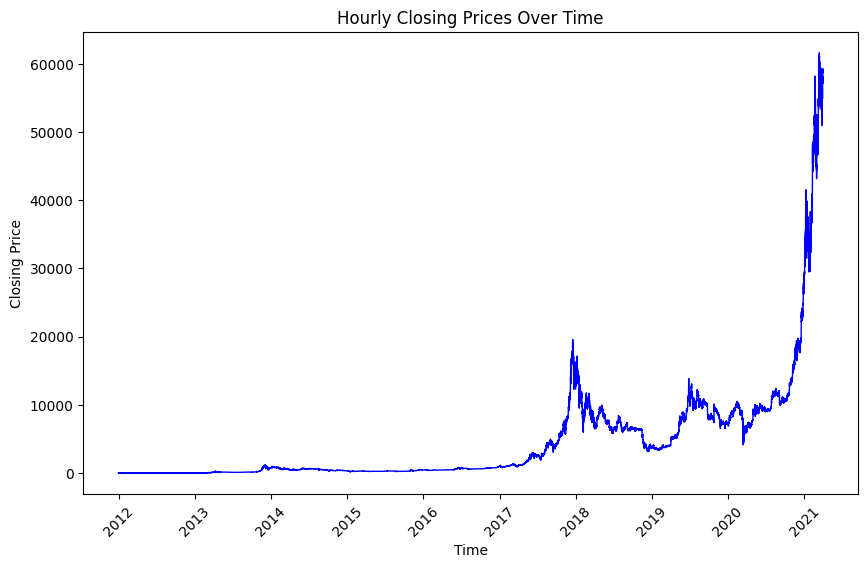

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hourly_data['Timestamp'], hourly_data['Close'], color='blue', linewidth=1) # Plot the closing prices
plt.title('Hourly Closing Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)  # Rotating x-axis labels
plt.show()

In [117]:
pip install imbalanced-learn

In [118]:
value_counts = hourly_data['overreaction'].value_counts()
print(value_counts)
daily_value_counts=daily_data['overreaction'].value_counts()
print(daily_value_counts)

overreaction
 0    77327
-1     1995
 1     1744
Name: count, dtype: int64
overreaction
 0    3182
-1     107
 1      90
Name: count, dtype: int64


In [119]:
hourly_data['Timestamp'] = pd.to_datetime(hourly_data['Timestamp'])
hourly_data_2016_onwards = hourly_data[hourly_data['Timestamp'].dt.year >= 2016]
hourly_data_2016_onwards.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),returns,overreaction
35081,2016-01-01 00:00:00,430.89,432.58,429.82,431.02,41.320972,-0.024261,0
35082,2016-01-01 01:00:00,431.51,432.01,429.08,430.01,31.212239,-0.001497,0
35083,2016-01-01 02:00:00,430.00,431.69,430.00,430.57,12.246236,-0.001942,0
35084,2016-01-01 03:00:00,430.50,433.37,430.03,433.37,74.984254,0.024811,0
35085,2016-01-01 04:00:00,433.34,435.72,432.55,435.11,870.803435,-0.006614,0


In [120]:
pip install ta

In [121]:
from ta import add_all_ta_features
hourly_data_2016_onwards = hourly_data_2016_onwards.copy()

# Calculating MovingAvg, RSI, MACD, etc.
training_data = add_all_ta_features(hourly_data_2016_onwards, open='Open', high='High', low='Low', close='Close', volume='Volume_(BTC)', fillna=True)

training_data = training_data[['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'returns','trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow','overreaction']]
training_data.head()

/usr/local/lib/python3.10/dist-packages/ta/volume.py:290: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  self._vpt = (self._close.pct_change() * self._volume).cumsum()
/usr/local/lib/python3.10/dist-packages/ta/volume.py:327: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  price_change = self._close.pct_change()


,Timestamp,Open,High,Low,Close,Volume_(BTC),returns,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,overreaction
35081,2016-01-01 00:00:00,430.89,432.58,429.82,431.02,41.320972,-0.024261,0.000000,0.000000,0.000000,431.020000,431.020000,431.020000,431.020000,0
35082,2016-01-01 01:00:00,431.51,432.01,429.08,430.01,31.212239,-0.001497,-0.080570,-0.016114,-0.064456,430.515000,430.515000,430.864615,430.945185,0
35083,2016-01-01 02:00:00,430.00,431.69,430.00,430.57,12.246236,-0.001942,-0.098104,-0.032512,-0.065592,430.533333,430.533333,430.819290,430.917394,0
35084,2016-01-01 03:00:00,430.50,433.37,430.03,433.37,74.984254,0.024811,0.112639,-0.003482,0.116120,431.242500,431.242500,431.211707,431.099068,0
35085,2016-01-01 04:00:00,433.34,435.72,432.55,435.11,870.803435,-0.006614,0.415270,0.080269,0.335001,432.016000,432.016000,431.811444,431.396174,0


In [122]:
nan_values_columnwise = training_data.isna().sum()
nan_values_columnwise

,0
Timestamp,0
Open,4
High,4
Low,4
Close,4
Volume_(BTC),0
returns,4
trend_macd,0
trend_macd_signal,0
trend_macd_diff,0


In [123]:
training_data['overreaction'] = training_data['overreaction'].astype(float)

columns = list(training_data.columns)
columns.remove('overreaction')
columns.append('overreaction')

training_data = training_data.reindex(columns=columns)
training_data.head()
#print(training_data.shape)

<ipython-input-123-e4c08a3659b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['overreaction'] = training_data['overreaction'].astype(float)


,Timestamp,Open,High,Low,Close,Volume_(BTC),returns,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,overreaction
35081,2016-01-01 00:00:00,430.89,432.58,429.82,431.02,41.320972,-0.024261,0.000000,0.000000,0.000000,431.020000,431.020000,431.020000,431.020000,0.0
35082,2016-01-01 01:00:00,431.51,432.01,429.08,430.01,31.212239,-0.001497,-0.080570,-0.016114,-0.064456,430.515000,430.515000,430.864615,430.945185,0.0
35083,2016-01-01 02:00:00,430.00,431.69,430.00,430.57,12.246236,-0.001942,-0.098104,-0.032512,-0.065592,430.533333,430.533333,430.819290,430.917394,0.0
35084,2016-01-01 03:00:00,430.50,433.37,430.03,433.37,74.984254,0.024811,0.112639,-0.003482,0.116120,431.242500,431.242500,431.211707,431.099068,0.0
35085,2016-01-01 04:00:00,433.34,435.72,432.55,435.11,870.803435,-0.006614,0.415270,0.080269,0.335001,432.016000,432.016000,431.811444,431.396174,0.0


OUTLIER REMOVAL

In [124]:
#print(training_data.count())
print('')
columns_to_handle_outliers=['Open','High',	'Low',	'Close',	'Volume_(BTC)',	'returns']
for i in columns_to_handle_outliers:
    Q1 =  training_data[i].quantile(0.25)
    Q3 =  training_data[i].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (training_data[i] < lower_bound) | (training_data[i] > upper_bound)
    training_data.loc[outliers, i] = None

processed_data= training_data.dropna()
#print(processed_data.count())
processed_data.head()
processed_data.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),returns,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,overreaction
78566,2020-12-16 21:00:00,20830.11,21320.61,20740.55,21215.49,844.146644,0.029919,412.926249,312.066449,100.859799,20503.992500,19927.133462,20539.161271,20126.235023,1.0
78567,2020-12-16 22:00:00,21206.50,21464.97,21203.77,21393.45,667.725259,-0.001532,450.487508,339.750661,110.736847,20636.969167,20000.024615,20670.590307,20220.102799,0.0
78568,2020-12-16 23:00:00,21393.55,21576.76,21218.58,21365.70,639.172448,-0.017849,472.568409,366.314211,106.254198,20771.340000,20074.542692,20777.530259,20304.961851,0.0
78569,2020-12-17 00:00:00,21358.96,21423.13,21244.04,21423.13,409.553895,0.007135,489.064175,390.864203,98.199972,20908.550000,20149.793846,20876.853296,20387.789121,0.0
78570,2020-12-17 01:00:00,21416.95,21880.00,21416.95,21738.47,680.886171,0.014474,521.570156,417.005394,104.564762,21024.955833,20238.393846,21009.409712,20487.839557,0.0


KNN

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Slicing
x = processed_data.iloc[:, 1:-1].values
y = processed_data.iloc[:, -1].values

# Removing the missing values
clean_indices = ~np.isnan(x).any(axis=1)
x_cleaned = x[clean_indices]
y_cleaned = y[clean_indices]

# StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_cleaned)

# Performing Principal component analysis

pca = PCA(0.85)
x_pca = pca.fit_transform(x_scaled)
x_train, x_test, y_train, y_test = train_test_split(x_pca, y_cleaned, test_size=0.3, random_state=40, stratify=y_cleaned)

# KNN MODEL
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
#print(np.unique(y_cleaned))
print("Accuracy:", round(accuracy * 100, 2), "%")

Accuracy: 97.5 %


In [147]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score (Weighted):", round(f1,3))

F1 Score (Weighted): 0.966


In [148]:
'''import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load your dataset here
# processed_data = pd.read_csv('your_data.csv')  # Example for loading your data

# Step 1: Convert Timestamp to datetime
processed_data['Timestamp'] = pd.to_datetime(processed_data['Timestamp'])

# Step 2: Data Preparation and Scaling
# Scale the necessary columns
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(processed_data[['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'returns',
                                                    'trend_macd', 'trend_macd_signal',
                                                    'trend_macd_diff', 'trend_sma_fast',
                                                    'trend_sma_slow', 'trend_ema_fast',
                                                    'trend_ema_slow']])

# Step 3: Create sequences for LSTM
n_past = 2  # Use the last 100 hours to predict the next hour's closing price
X, y = [], []

for i in range(n_past, len(scaled_data)):
    X.append(scaled_data[i - n_past:i, :])  # Use 'n_past' hours of data as features
    y.append(scaled_data[i, 3])  # The target is the 'Close' price (index 3)

X, y = np.array(X), np.array(y)

# Step 4: Train-test split (80% training, 20% testing)
split = int(0.8 * len(X))  # 80% for training, 20% for testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Extract corresponding timestamps for the test data
test_timestamps = processed_data['Timestamp'][split + n_past:].reset_index(drop=True)

# Step 5: Build the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_past, X.shape[2])))
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(LSTM(units=50, return_sequences=False))  # Last LSTM layer
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 6: Train the Model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

predicted_prices = model.predict(X_test)

# Inverse scale the predictions back to the original scale
n_features = 13  # Based on your scaled data shape
predicted_prices_scaled = np.zeros((predicted_prices.shape[0], n_features))  # Initialize with zeros
predicted_prices_scaled[:, 3] = predicted_prices.flatten()  # Assign the predicted prices to the 'Close' column

predicted_prices = scaler.inverse_transform(predicted_prices_scaled)[:, 3]  # Inverse transform

# Inverse scale the true test set 'Close' prices
true_prices_scaled = np.zeros((y_test.shape[0], n_features))  # Initialize with zeros
true_prices_scaled[:, 3] = y_test.flatten()  # Assign the true prices to the 'Close' column

true_prices = scaler.inverse_transform(true_prices_scaled)[:, 3]  # Inverse transform

# Step 8: Evaluate the Model (Plotting with Timestamps)
plt.figure(figsize=(14, 5))
plt.plot(test_timestamps, true_prices, color='blue', label='True BTC Prices')
plt.plot(test_timestamps, predicted_prices, color='red', label='Predicted BTC Prices')
plt.title('BTC Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.xticks(rotation=45)  # Rotate the X-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

# Step 9: Calculate and display evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics
mse = mean_squared_error(true_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_prices, predicted_prices)
r2 = r2_score(true_prices, predicted_prices)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R² Score: {r2}')'''

"import numpy as np\nimport pandas as pd\nfrom sklearn.preprocessing import MinMaxScaler\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense, Dropout\nimport matplotlib.pyplot as plt\n\n# Load your dataset here\n# processed_data = pd.read_csv('your_data.csv')  # Example for loading your data\n\n# Step 1: Convert Timestamp to datetime\nprocessed_data['Timestamp'] = pd.to_datetime(processed_data['Timestamp'])\n\n# Step 2: Data Preparation and Scaling\n# Scale the necessary columns\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaled_data = scaler.fit_transform(processed_data[['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'returns', \n                                                    'trend_macd', 'trend_macd_signal', \n                                                    'trend_macd_diff', 'trend_sma_fast', \n                                                    'trend_sma_slow', 'trend_ema_fast', \n                                           

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
962/962 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0048 - val_loss: 3.5508e-04
Epoch 2/5
962/962 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 4.8711e-04 - val_loss: 1.5416e-04
Epoch 3/5
962/962 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.7620e-04 - val_loss: 1.8430e-04
Epoch 4/5
962/962 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 3.1546e-04 - val_loss: 1.0240e-04
Epoch 5/5
962/962 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 3.1080e-04 - val_loss: 1.1975e-04
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


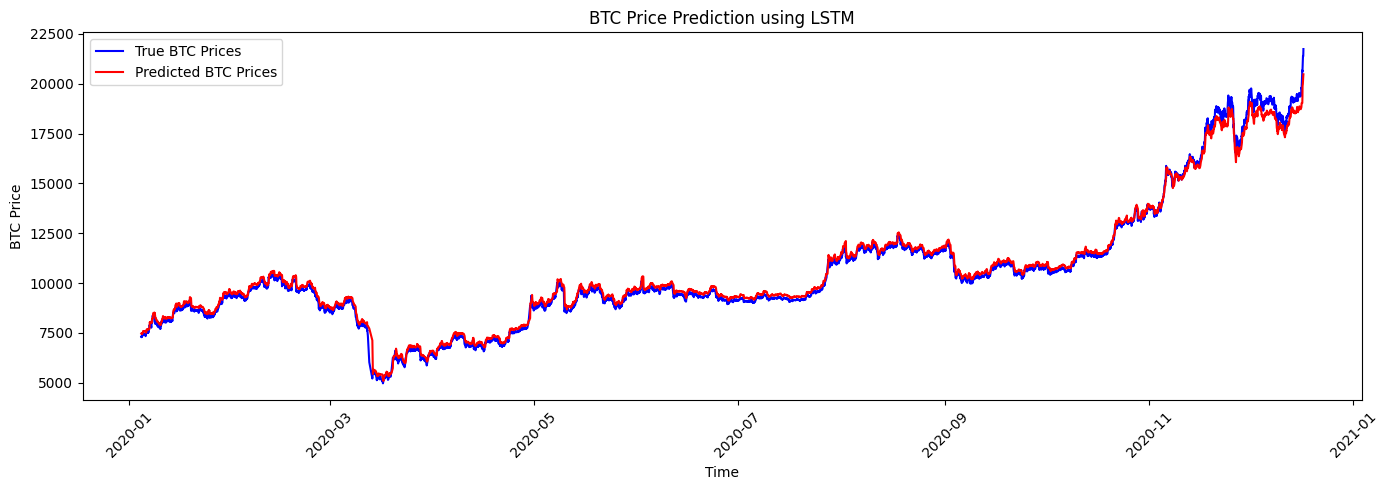

MSE: 54735.33502211899
RMSE: 233.95583989744514
MAE: 191.04564724080998
R² Score: 0.9945575470322752


In [159]:


import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load your dataset here
df_btc = processed_data

# Step 1: Convert Timestamp to datetime
df_btc['Timestamp'] = pd.to_datetime(df_btc['Timestamp'])

# Step 2: Data Preparation and Scaling
# Scale the necessary columns
scaler_btc = MinMaxScaler(feature_range=(0, 1))
scaled_btc = scaler_btc.fit_transform(df_btc[['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'returns',
                                               'trend_macd', 'trend_macd_signal',
                                               'trend_macd_diff', 'trend_sma_fast',
                                               'trend_sma_slow', 'trend_ema_fast',
                                               'trend_ema_slow']])

# Step 3: Create sequences for LSTM
n_past = 2  # Use the last 2 hours/days to predict the next hour/day's closing price
X_btc, y_btc = [], []

for i in range(n_past, len(scaled_btc)):
    X_btc.append(scaled_btc[i - n_past:i, :])  # Use 'n_past' time points as features
    y_btc.append(scaled_btc[i, 3])  # The target is the 'Close' price (index 3)

X_btc, y_btc = np.array(X_btc), np.array(y_btc)

# Step 4: Train-test split (80% training, 20% testing)
split_btc = int(0.8 * len(X_btc))  # 80% for training, 20% for testing
X_train_btc, X_test_btc = X_btc[:split_btc], X_btc[split_btc:]
y_train_btc, y_test_btc = y_btc[:split_btc], y_btc[split_btc:]

# Extract corresponding timestamps for the test data
test_timestamps_btc = df_btc['Timestamp'][split_btc + n_past:].reset_index(drop=True)

# Step 5: Build the LSTM Model
model_btc = Sequential()
model_btc.add(LSTM(units=50, return_sequences=True, input_shape=(n_past, X_btc.shape[2])))
model_btc.add(Dropout(0.2))  # Add dropout for regularization
model_btc.add(LSTM(units=50, return_sequences=False))  # Last LSTM layer
model_btc.add(Dropout(0.2))
model_btc.add(Dense(units=1))  # Output layer

# Compile the model
model_btc.compile(optimizer='adam', loss='mean_squared_error')

# Step 6: Train the Model
model_btc.fit(X_train_btc, y_train_btc, epochs=5, batch_size=32, validation_data=(X_test_btc, y_test_btc))

predicted_prices_btc = model_btc.predict(X_test_btc)

# Inverse scale the predictions back to the original scale
n_features_btc = 13  # Based on your scaled data shape
predicted_prices_scaled_btc = np.zeros((predicted_prices_btc.shape[0], n_features_btc))  # Initialize with zeros
predicted_prices_scaled_btc[:, 3] = predicted_prices_btc.flatten()  # Assign the predicted prices to the 'Close' column

predicted_prices_btc = scaler_btc.inverse_transform(predicted_prices_scaled_btc)[:, 3]  # Inverse transform

# Inverse scale the true test set 'Close' prices
true_prices_scaled_btc = np.zeros((y_test_btc.shape[0], n_features_btc))  # Initialize with zeros
true_prices_scaled_btc[:, 3] = y_test_btc.flatten()  # Assign the true prices to the 'Close' column

true_prices_btc = scaler_btc.inverse_transform(true_prices_scaled_btc)[:, 3]  # Inverse transform

# Step 8: Evaluate the Model (Plotting with Timestamps)
plt.figure(figsize=(14, 5))
plt.plot(test_timestamps_btc, true_prices_btc, color='blue', label='True BTC Prices')
plt.plot(test_timestamps_btc, predicted_prices_btc, color='red', label='Predicted BTC Prices')
plt.title('BTC Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.xticks(rotation=45)  # Rotate the X-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

# Step 9: Calculate and display evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics
mse_btc = mean_squared_error(true_prices_btc, predicted_prices_btc)
rmse_btc = np.sqrt(mse_btc)
mae_btc = mean_absolute_error(true_prices_btc, predicted_prices_btc)
r2_btc = r2_score(true_prices_btc, predicted_prices_btc)

print(f'MSE: {mse_btc}')
print(f'RMSE: {rmse_btc}')
print(f'MAE: {mae_btc}')
print(f'R² Score: {r2_btc}')


# Testing Data

In [149]:
'''!pip install ccxt'''

'!pip install ccxt'

In [150]:
'''pip install python-binance'''

'pip install python-binance'

In [160]:
testing_data=pd.read_csv('/content/gdrive/MyDrive/testingdata_BTC.zip')
testing_data['Date'] = pd.to_datetime(testing_data['Date'], errors='coerce') # Handling errors in datetime


filtered_data = testing_data[(testing_data['Date'].dt.year == 2022) | (testing_data['Date'].dt.year == 2023)]

filtered_data.drop(columns=['Symbol','tradecount','Volume USDT'],inplace=True)
filtered_data['returns'] = ((filtered_data['Close'] / filtered_data['Open']) - 1) * 100
reversed_data = filtered_data.iloc[::-1]

reversed_data.head()
reversed_data.tail()

<ipython-input-160-2f874fa3838d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.drop(columns=['Symbol','tradecount','Volume USDT'],inplace=True)
<ipython-input-160-2f874fa3838d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['returns'] = ((filtered_data['Close'] / filtered_data['Open']) - 1) * 100


,Date,Open,High,Low,Close,Volume BTC,returns
4,2023-10-19 19:00:00,28646.98,28765.76,28645.00,28750.75,1039.20935,0.362237
3,2023-10-19 20:00:00,28750.75,28882.07,28684.80,28715.38,1737.14711,-0.123023
2,2023-10-19 21:00:00,28715.39,28739.73,28604.09,28604.09,1118.51697,-0.387597
1,2023-10-19 22:00:00,28604.09,28704.99,28598.60,28649.65,767.85518,0.159278
0,2023-10-19 23:00:00,28649.64,28717.82,28630.19,28713.71,613.28448,0.223633


In [161]:
# Preprocess the new data
reversed_data_copy = reversed_data.copy()

training_data = add_all_ta_features(reversed_data_copy, open='Open', high='High', low='Low', close='Close', volume='Volume BTC', fillna=True)

training_data = training_data.loc[:, ['Date', 'Open', 'High', 'Low', 'Close', 'Volume BTC', 'returns','trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow']]

new_x = training_data.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume BTC', 'returns', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow']].values


clean_indices_new = ~np.isnan(new_x).any(axis=1)
new_x_cleaned = new_x[clean_indices_new]

new_x_scaled = scaler.transform(new_x_cleaned)
new_x_pca = pca.transform(new_x_scaled)
new_y_pred = knn.predict(new_x_pca)

print("Predicted overrelation for new data:", new_y_pred)


Predicted overrelation for new data: [0. 0. 0. ... 0. 0. 0.]


In [162]:
unique_values, counts = np.unique(new_y_pred, return_counts=True)
print(dict(zip(unique_values, counts)))

{-1.0: 33, 0.0: 15690, 1.0: 43}


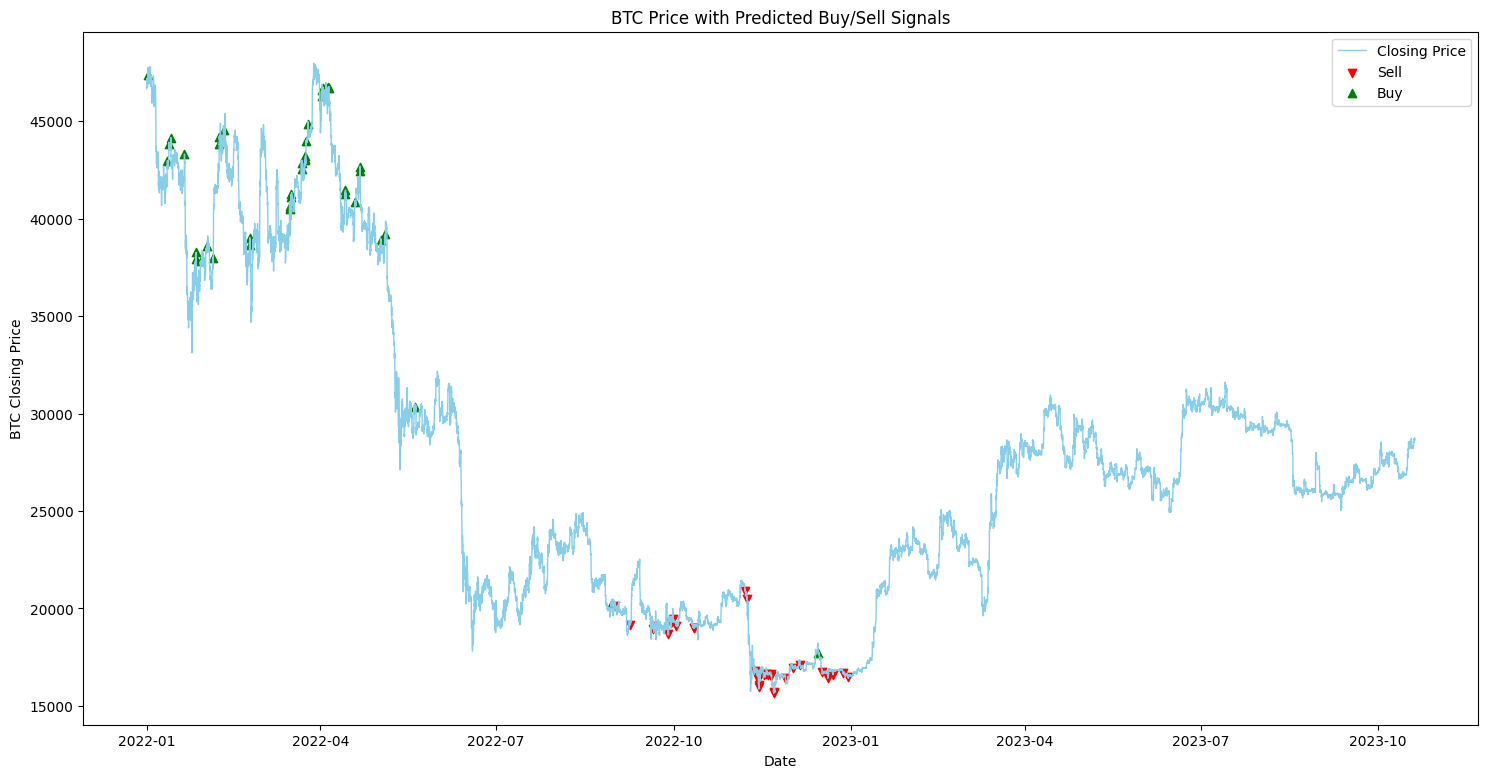

In [154]:
import matplotlib.pyplot as plt

timestamps=reversed_data['Date']
closing_prices=reversed_data['Close']

predicted_df = pd.DataFrame({'Timestamp': timestamps, 'Close': closing_prices})

predicted_df['Predicted Overreaction'] = new_y_pred

plt.figure(figsize=(18, 9))
plt.plot(predicted_df['Timestamp'], predicted_df['Close'], color='skyblue', label='Closing Price',linewidth=1)

# Plot the predicted overreaction values with different markers or colors
sell_points = predicted_df[predicted_df['Predicted Overreaction'] == -1.0]
buy_points = predicted_df[predicted_df['Predicted Overreaction'] == 1.0]
plt.scatter(sell_points['Timestamp'], sell_points['Close'], color='red', label='Sell', marker='v')
plt.scatter(buy_points['Timestamp'], buy_points['Close'], color='green', label='Buy', marker='^')

plt.xlabel('Date')
plt.ylabel('BTC Closing Price')
plt.title('BTC Price with Predicted Buy/Sell Signals')
plt.legend()
plt.show()

CALCULATING PROFIT PERCENTAGE

In [155]:
import pandas as pd

reversed_data['Predicted Overreaction'] = new_y_pred
grouped_data = reversed_data.groupby(reversed_data['Date'].dt.date) #Grouping date so that we can calculate the returns for entire day

total_returns = {}

for date, group in grouped_data:
    day_data = group[group['Date'].dt.date == date]
    buy_signals = (day_data['Predicted Overreaction'] == 1.0)
    sell_signals = (day_data['Predicted Overreaction'] == -1.0)

    buy_returns = day_data.loc[buy_signals, 'returns']
    sell_returns = day_data.loc[sell_signals, 'returns']

    buy_profit_loss = (buy_returns / 100)  # Since they are in percentage
    sell_profit_loss = -(sell_returns / 100)


    total_return = buy_profit_loss.sum() + sell_profit_loss.sum()
    total_returns[date] = total_return

total_returns_df = pd.DataFrame.from_dict(total_returns, orient='index', columns=['Total Return'])
#print(total_returns_df)
non_zero_returns_df = total_returns_df[total_returns_df['Total Return'] != 0]

non_zero_returns_df.head()

<ipython-input-155-35fc071ae180>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reversed_data['Predicted Overreaction'] = new_y_pred


,Total Return
2022-01-01,0.001311
2022-01-11,0.005077
2022-01-12,0.005286
2022-01-13,0.005234
2022-01-20,0.007890


In [156]:
initial_investment = 10000

non_zero_returns_df['Final Value if invested'] = initial_investment * (1 + non_zero_returns_df['Total Return'])
non_zero_returns_df.head()

<ipython-input-156-f4f008032d6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zero_returns_df['Final Value if invested'] = initial_investment * (1 + non_zero_returns_df['Total Return'])


,Total Return,Final Value if invested
2022-01-01,0.001311,10013.105911
2022-01-11,0.005077,10050.768343
2022-01-12,0.005286,10052.862773
2022-01-13,0.005234,10052.341956
2022-01-20,0.007890,10078.897511


In [157]:
total_return_sum = non_zero_returns_df['Total Return'].sum()

total_returns = total_return_sum * initial_investment
print("Total Returns:", round(total_returns,2),'$')

ROI_percentage = (total_returns / initial_investment) * 100
print("ROI (Return on Investment) percentage:", round(ROI_percentage,2), "%")

Total Returns: 4674.72 $
ROI (Return on Investment) percentage: 46.75 %
